<a href="https://colab.research.google.com/github/nina-prog/DataAnalysis_VAE/blob/main/VAE_v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Preprocessing

---



## Load Data

In [25]:
### Load ecg5000 data using read_csv
ecg5000 = pd.read_csv('ECG5000_ALL.txt', sep='\s+', header=None)
#print(ecg5000.head)

### Delete label-column first (column 0)
#ecg5000.drop(ecg5000.columns[[0]], axis=1, inplace=True)

In [26]:
### Optional test and info about data set
print("Type of ecg5000: \t \t {}".format(type(ecg5000)))
print("Dimensions of ecg5000: \t \t {}".format(ecg5000.shape))
print("Number of elements of ecg5000: \t {}".format((ecg5000.size)))
print("Display first 10 rows of ecg5000: \n {}".format(ecg5000.head(10)))

Type of ecg5000: 	 	 <class 'pandas.core.frame.DataFrame'>
Dimensions of ecg5000: 	 	 (5000, 141)
Number of elements of ecg5000: 	 705000
Display first 10 rows of ecg5000: 
    0         1         2         3    ...       137       138       139       140
0  1.0 -0.112522 -2.827204 -3.773897  ...  0.228077  0.123431  0.925286  0.193137
1  1.0 -1.100878 -3.996840 -4.285843  ...  0.476333  0.773820  1.119621 -1.436250
2  1.0 -0.567088 -2.593450 -3.874230  ... -0.532197  0.321097  0.904227 -0.421797
3  1.0  0.490473 -1.914407 -3.616364  ...  0.990133  1.086798  1.403011 -0.383564
4  1.0  0.800232 -0.874252 -2.384761  ...  0.960304  0.971020  1.614392  1.421456
5  1.0 -1.507674 -3.574550 -4.478011  ...  1.007076  1.634990  1.493366 -0.783134
6  1.0 -0.297161 -2.766635 -4.102185  ...  0.974787  1.110407  1.288165 -0.823386
7  1.0  0.446769 -1.507397 -3.187468  ...  1.034388  1.258433  0.961215 -0.999476
8  1.0  0.087631 -1.753490 -3.304473  ...  0.573453  0.192971 -0.648683 -2.441068
9  1.0

In [27]:
### Get YLabel df
dfYLabel = ecg5000.iloc[:,0]

### Normalize dataframe with min-max-normalization to range between [-0.8, 0.8] using sklearn MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-0.8,0.8))
scaled_ecg5000 = pd.DataFrame(min_max_scaler.fit_transform(ecg5000))
print(scaled_ecg5000)

      0         1         2         3    ...       137       138       139       140
0    -0.8  0.105202 -0.154680 -0.521072  ...  0.183241  0.190712  0.256566 -0.054755
1    -0.8 -0.030005 -0.331729 -0.626180  ...  0.231023  0.305374  0.286734 -0.247949
2    -0.8  0.043017 -0.119297 -0.541672  ...  0.036911  0.225560  0.253297 -0.127667
3    -0.8  0.187692 -0.016509 -0.488729  ...  0.329914  0.360551  0.330726 -0.123133
4    -0.8  0.230067  0.140940 -0.235867  ...  0.324173  0.340140  0.363540  0.090885
...   ...       ...       ...       ...  ...       ...       ...       ...       ...
4995  0.4 -0.033027 -0.067751 -0.335005  ... -0.632409 -0.337752 -0.198844 -0.292066
4996 -0.4  0.045669 -0.012746 -0.329288  ...  0.369043  0.391322  0.291519  0.017785
4997 -0.4 -0.064328 -0.061103 -0.263680  ... -0.522184 -0.229486 -0.132008 -0.158819
4998 -0.4 -0.033227 -0.015091 -0.196437  ... -0.103605  0.090797  0.026031 -0.064782
4999 -0.4  0.220296  0.302430  0.103076  ...  0.476928  0.440269 

## Split Data

In [28]:
### Split Data into 80/20 Training, Test
trainDF, testDF = train_test_split(scaled_ecg5000, test_size=0.2, shuffle=False)

# Get all labels from trainDF and then drop it
trainDF_Y = trainDF.iloc[:,0]
trainDF.drop(trainDF.columns[[0]], axis=1, inplace=True)

# Get all labels from testDF and then drop it
testDF_Y = testDF.iloc[:,0]
testDF.drop(testDF.columns[[0]], axis=1, inplace=True)


# Optional test and info about new data sets
print("Shape of Training DataFrame: \t {}".format(trainDF.shape))
print("Shape of Test DataFrame: \t {}".format(testDF.shape))
print("Shape of Train Y DataFrame: \t {}".format(trainDF_Y.shape))
print("Shape of Test Y DataFrame: \t {}".format(testDF_Y.shape))

Shape of Training DataFrame: 	 (4000, 140)
Shape of Test DataFrame: 	 (1000, 140)
Shape of Train Y DataFrame: 	 (4000,)
Shape of Test Y DataFrame: 	 (1000,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Reshape Data

In [29]:
### Convert to array
x_train = trainDF.to_numpy()
x_test = testDF.to_numpy()

y_train = trainDF_Y.to_numpy()
y_test = testDF_Y.to_numpy()

### Reshape input into [samples, timesteps, features]
s_train = len(trainDF.index) # samples
s_test = len(testDF.index) # samples
n_train = len(trainDF.columns) # time steps
n_test = len(testDF.columns) # time steps
x_train = x_train.reshape(s_train, n_train, 1)
x_test = x_test.reshape(s_test, n_test, 1)

y_train = y_train.reshape(len(trainDF_Y.index), 1, 1)
y_test = y_test.reshape(len(testDF_Y.index), 1, 1)

### Properties
print("Shape of reshaped train dataset: {}".format(x_train.shape))
print("Shape of reshaped test dataset: {}".format(x_test.shape))

print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of reshaped train dataset: (4000, 140, 1)
Shape of reshaped test dataset: (1000, 140, 1)
Shape of y_train: (4000, 1, 1)
Shape of y_test: (1000, 1, 1)


# Create Sample Layer

---



In [30]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build Variational Autoencoder (VAE)

---



## Define Model

In [31]:
### For better understanding visit: https://towardsdatascience.com/autoencoders-for-the-compression-of-stock-market-data-28e8c1a2da3e
### For better understanding of layers and Recreating auto encoders visit: https://machinelearningmastery.com/lstm-autoencoders/
### or for code: https://gist.github.com/GerardBCN/40349b39bc45d4550141aff6966d1619#file-stock_price_autoencoding-ipynb
### For Reshaping Issues: https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

### Model Properties
encoding_dim = 140
latent_dim = 5
epochs = 20
batch_size = 32
drop_out_rate = 0.5


## Encoder

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input_layer (InputLayer [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
Encode_1 (Bidirectional)        (None, 280)          159040      Encoder_Input_layer[0][0]        
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 280)          0           Encode_1[0][0]                   
__________________________________________________________________________________________________
Encode_2 (Dense)                (None, 5)            1405        dropout_3[0][0]                  
____________________________________________________________________________________________

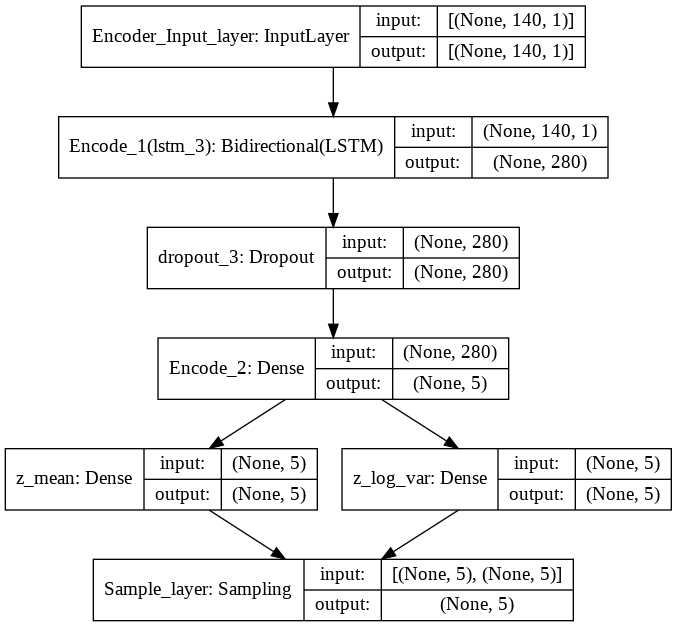

In [32]:
### Define Encoder Layers
encoder_inputs = keras.Input(shape=(140, 1), name='Encoder_Input_layer')

encoded = Bidirectional(layers.LSTM(encoding_dim, activation='tanh', name=''), name='Encode_1')(encoder_inputs)
dropout = layers.Dropout(rate = drop_out_rate)(encoded)
encoded = layers.Dense(5, activation='tanh', name='Encode_2')(dropout) #5, because 5 class in data ecg5000 - evtl 2,1
z_mean = layers.Dense(latent_dim, activation="softplus", name="z_mean")(encoded) 
z_log_var = layers.Dense(latent_dim, activation="softplus", name="z_log_var")(encoded)

z = Sampling(name='Sample_layer')([z_mean, z_log_var])

### Build Encoder
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder") # 

encoder.summary()
# configure encoder for training
encoder.compile(optimizer='adam', loss='mean_squared_error')

plot_model(encoder, show_shapes=True, to_file='reconstruct_lstm_encoder.png')

## Decoder

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input_layer (InputLa [(None, 5)]               0         
_________________________________________________________________
Decode_1 (Dense)             (None, 140)               840       
_________________________________________________________________
Decode_2 (Reshape)           (None, 140, 1)            0         
_________________________________________________________________
Decode_3 (Bidirectional)     (None, 140, 280)          159040    
_________________________________________________________________
dropout_4 (Dropout)          (None, 140, 280)          0         
_________________________________________________________________
Decoder_Output_Layer (TimeDi (None, 140, 1)            281       
Total params: 160,161
Trainable params: 160,161
Non-trainable params: 0
_____________________________________________________

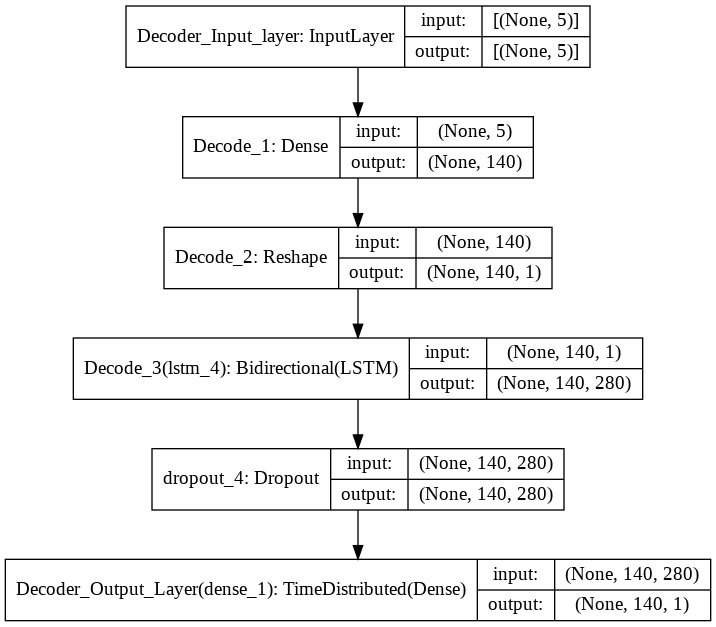

In [33]:
### Define Decoder Layers
latent_inputs = keras.Input(shape=(latent_dim,), name='Decoder_Input_layer')

decoded = layers.Dense(140, activation='tanh', name='Decode_1')(latent_inputs)
decoded = layers.Reshape((140,1), name='Decode_2')(decoded)
decoded = Bidirectional(layers.LSTM(encoding_dim, return_sequences=True, activation='tanh', name=''), name='Decode_3')(decoded)
dropout = layers.Dropout(rate=drop_out_rate)(decoded)

decoder_outputs = TimeDistributed(Dense(1, activation='tanh', name=''),name='Decoder_Output_Layer')(dropout)

### Build Decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()
# configure decoder for training
decoder.compile(optimizer='adam', loss='mean_squared_error')

plot_model(decoder, show_shapes=True, to_file='reconstruct_lstm_decoder.png')

## Connecting the Encoder and Decoder

Model: "vae_v2_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_Input_layer (InputLa [(None, 140, 1)]          0         
_________________________________________________________________
encoder (Functional)         [(None, 5), (None, 5), (N 160505    
_________________________________________________________________
decoder (Functional)         (None, 140, 1)            160161    
Total params: 320,666
Trainable params: 320,666
Non-trainable params: 0
_________________________________________________________________


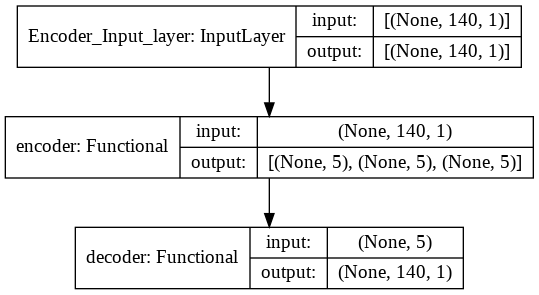

In [34]:
### For better understanding visit https://becominghuman.ai/using-variational-autoencoder-vae-to-generate-new-images-14328877e88d

### Instantiate VAE model
# The output of vae model is the output of decoder in which its input is taken from the output of encoder !
decoder_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, decoder_outputs, name='vae_v2_0')
# vae.compile(optimizer='adam', loss='binary_crossentropy')

vae.summary()
plot_model(vae, show_shapes=True, to_file='reconstruct_lstm_variational_autoencoder.png')

# Train VAE

---



## Define Train Model

In [35]:
class VAE(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            # reconstruction_loss = distance between Input and Output
            reconstruction_loss = tf.reduce_mean(
                #Alternative: keras.losses.binary_crossentropy(data, reconstruction)
                keras.losses.mean_squared_error(data, reconstruction)
            )
            # reconstruction_loss *= 28 * 28
            # kl_loss = distance between distributions and thus ensures the regular laten space
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstructed = self.decoder(z)  
        # Add KL divergence regularization loss.
        # kl_loss = -0.5 * tf.reduce_mean(
        #     z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        # )
        # self.add_loss(kl_loss)
        return reconstructed

## Train

In [36]:
### To improve training see here: https://becominghuman.ai/using-variational-autoencoder-vae-to-generate-new-images-14328877e88d
 
### Train
vae = VAE(encoder, decoder, name="VAE")
vae.compile(optimizer='adam', loss='mean_squared_error')
history = vae.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/20
125/125 [==============================] - 28s 184ms/step - loss: 0.2742 - reconstruction_loss: 0.0334 - kl_loss: 0.2408 - val_loss: 0.3077
Epoch 2/20
125/125 [==============================] - 22s 172ms/step - loss: 0.1213 - reconstruction_loss: 0.0266 - kl_loss: 0.0947 - val_loss: 0.3022
Epoch 3/20
125/125 [==============================] - 22s 173ms/step - loss: 0.0692 - reconstruction_loss: 0.0250 - kl_loss: 0.0442 - val_loss: 0.3050
Epoch 4/20
125/125 [==============================] - 22s 173ms/step - loss: 0.0488 - reconstruction_loss: 0.0241 - kl_loss: 0.0248 - val_loss: 0.3120
Epoch 5/20
125/125 [==============================] - 21s 171ms/step - loss: 0.0400 - reconstruction_loss: 0.0237 - kl_loss: 0.0163 - val_loss: 0.3084
Epoch 6/20
125/125 [==============================] - 21s 172ms/step - loss: 0.0350 - reconstruction_loss: 0.0234 - kl_loss: 0.0117 - val_loss: 0.3040
Epoch 7/20
125/125 [==============================] - 22s 173ms/step - loss: 0.0319 - reconstr

In [37]:
### Recreation
# Encoder output is a list [z_mean, z_log_var, z] thus list[2] = z, see subsection encoder line 12

# Extract myu i.e. z_mean
z_mean = encoder.predict(x_test)[0]
print("----- z_mean: -----")
print(z_mean)
print("\n")

# Extract sigma i.e. z_log_var
z_log_var = encoder.predict(x_test)[1]
print("----- z_log_var: -----")
print(z_log_var)
print("\n")

# Predict x_test through encoder then through decoder
z_values = encoder.predict(x_test)[2] # z values
decoded_ecg5000 = decoder.predict(z_values)

# z_values contains list of each z_value per sample, i.e. we get 1000 SubLists with 5 elements in each.
# Those 5 elements (z_values for Sample i) is our bottleneck which the decoder
# recieves.
print("----- z_values: -----")
print(z_values)
print("\n")

# Or predict directly through the VAE (Should do the same??? Not sure...)
# decoded_ecg5000_through_VAE = vae.predict(x_test)

print("Shape of z_mean: {}".format(z_mean.shape))
print("Shape of z_log_var: {}".format(z_log_var.shape))
print("Shape of decoded_ecg5000: {}".format(decoded_ecg5000.shape))
print("Shape of z_values: {}".format(z_values.shape))

# print("Shape of decoded_exg5000 through the VAE: {}".format(decoded_ecg5000_through_VAE.shape))

----- z_mean: -----
[[0.03137662 0.04718685 0.05876837 0.03769519 0.04193547]
 [0.03137664 0.04718687 0.05876837 0.03769519 0.04193548]
 [0.03137663 0.04718685 0.05876837 0.03769519 0.04193548]
 ...
 [0.03137663 0.04718684 0.05876837 0.03769519 0.04193547]
 [0.03137663 0.04718687 0.05876837 0.03769519 0.04193547]
 [0.03137664 0.04718687 0.05876837 0.03769519 0.04193548]]


----- z_log_var: -----
[[0.03075855 0.02205693 0.02163488 0.02460885 0.02409977]
 [0.03075856 0.02205694 0.02163488 0.02460886 0.02409977]
 [0.03075855 0.02205693 0.02163488 0.02460885 0.02409977]
 ...
 [0.03075855 0.02205693 0.02163488 0.02460885 0.02409977]
 [0.03075855 0.02205693 0.02163487 0.02460885 0.02409977]
 [0.03075855 0.02205694 0.02163488 0.02460885 0.02409977]]


----- z_values: -----
[[-0.21880376 -1.0079621   1.7138432  -0.31041512 -0.6973741 ]
 [-0.17782456 -0.00653991  0.9070789  -0.1128417  -0.53455657]
 [-1.2982908   0.32836214  1.2424313   1.7642877  -0.12243456]
 ...
 [ 0.9434546   0.3984862  -0.

## Display the training progress

Text(0.5, 1.0, 'Loss vs. Reconstruction Loss')

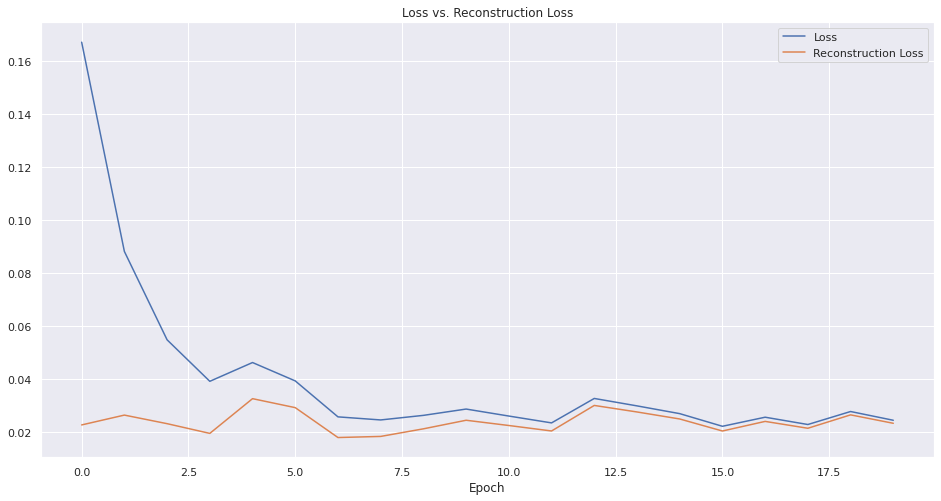

In [38]:
### Loss vs Reconstruction_loss
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['reconstruction_loss'])
plt.legend(["Loss", "Reconstruction Loss"])
plt.xlabel("Epoch")
plt.title("Loss vs. Reconstruction Loss")

Text(0.5, 1.0, 'Loss vs. Validation Loss')

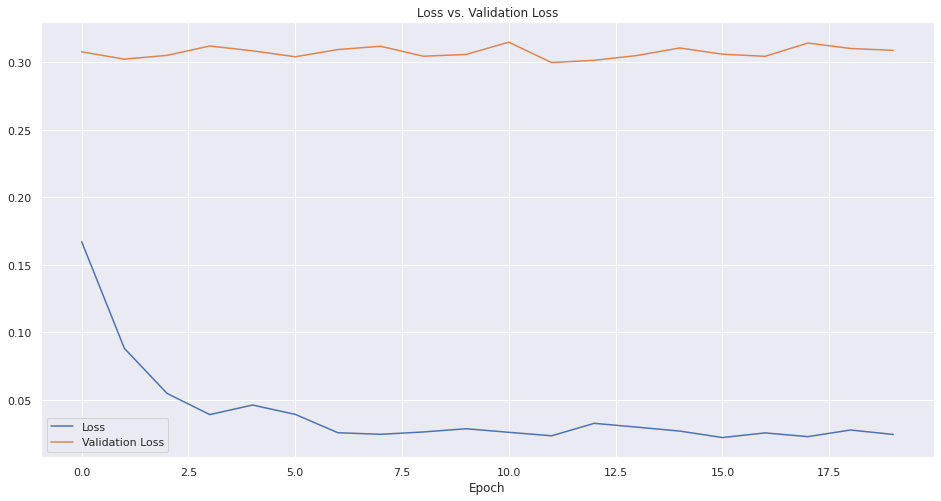

In [39]:
### Train loss vs val loss
#Returns the loss value & metrics values for the model in test mode
#val = vae.evaluate(x_test)
#print(val)

plt.figure(figsize=(16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.title("Loss vs. Validation Loss")

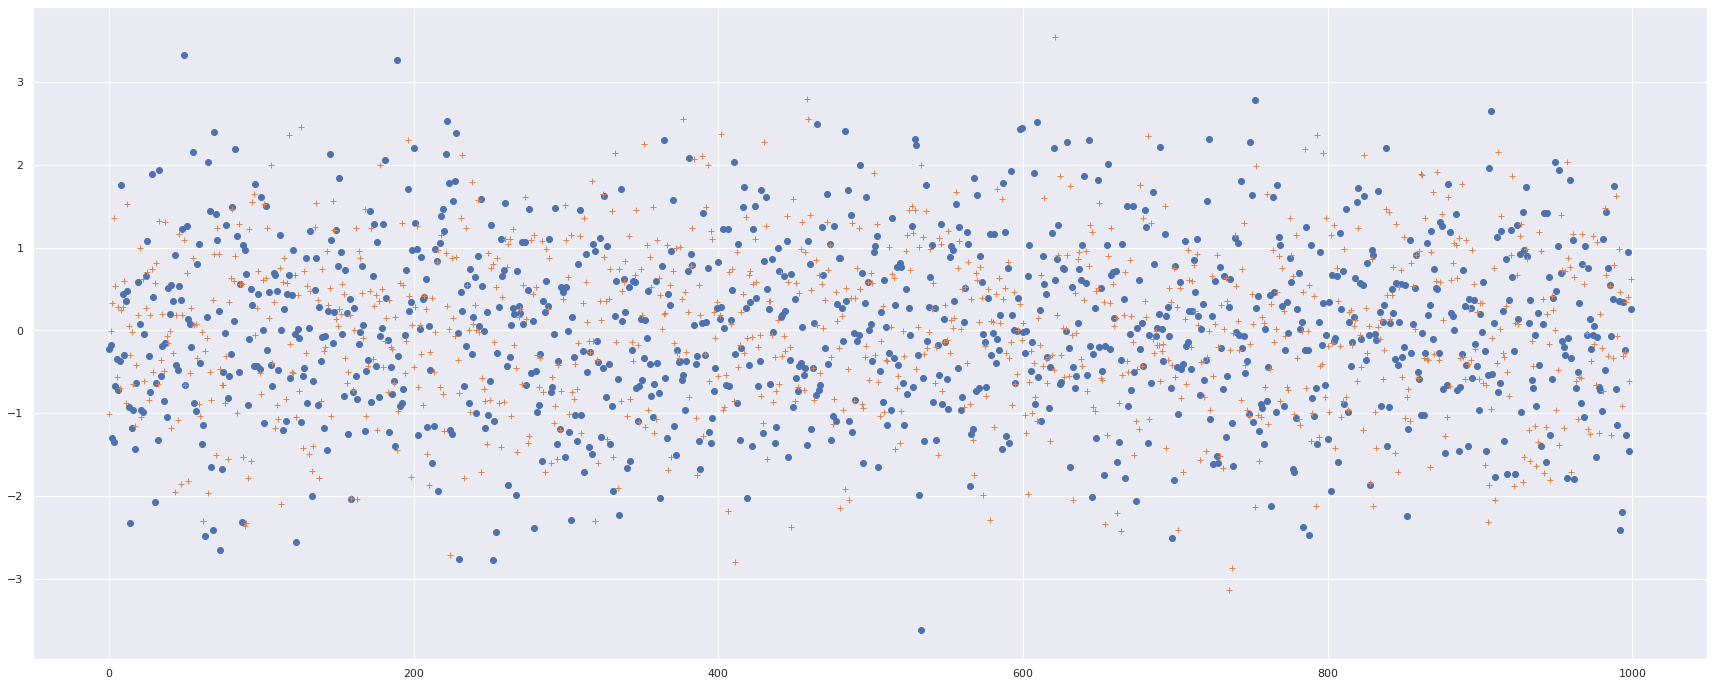

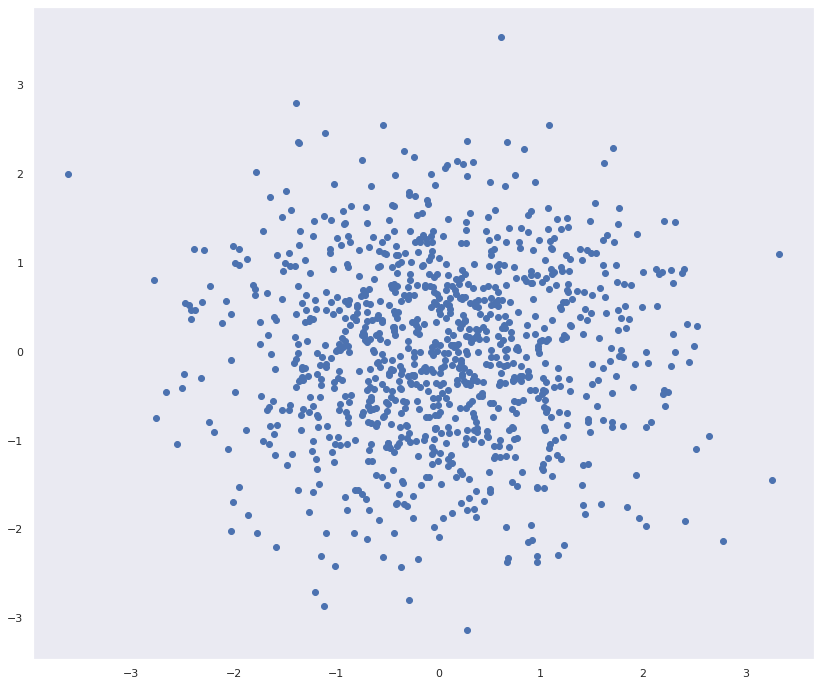

In [40]:
##################################################################################### TODO: Display latent space
### Encode data into latent space and show the distribution via normal plot

plt.figure(figsize=(30,12), linewidth=1)
plt.plot(z_values[:,0], 'o')
plt.plot(z_values[:,1], '+')
plt.show()

## ... via Scatterplot
# *i unpacks i into a tuple (i[0], i[1]), which is interpreted as (x,y) by plt.scatter
# for i in bottleneck:
#   plt.scatter(*i)

plt.figure(figsize=(14,12))
plt.scatter(z_values[:,0], z_values[:,1])
#plt.colorbar()
plt.grid()
plt.show()

# Plot Results

---



In [41]:
### Test if Input fits Dim of Output
print("Shape of Input x_train: {}".format(x_train.shape))
print("Shape of Output x_hat_train: {}".format(decoded_ecg5000.shape))

### Covert to 2D Array -- ("-1" = make a dimension (here rows) the size that will use the remaining unspecified elements)
new_x_train= x_train.reshape(-1,140)
new_decoded_ecg5000 = decoded_ecg5000.reshape(-1,140)

print("Shape of Input after reshaping: {}".format(new_x_train.shape))
print("Shape of Output after reshaping: {}".format(new_decoded_ecg5000.shape))

print("\n")
print("----- Decoded ECG5000 / Output of our VAE / x_hat_train ------")
print(new_decoded_ecg5000)

Shape of Input x_train: (4000, 140, 1)
Shape of Output x_hat_train: (1000, 140, 1)
Shape of Input after reshaping: (4000, 140)
Shape of Output after reshaping: (1000, 140)


----- Decoded ECG5000 / Output of our VAE / x_hat_train ------
[[ 0.07644526 -0.00834698 -0.3373023  ...  0.16153733  0.08748385
  -0.07136203]
 [ 0.07190418 -0.01561902 -0.33526558 ...  0.15659928  0.08685435
  -0.08379728]
 [ 0.06739415 -0.00610053 -0.32313544 ...  0.14376903  0.09955142
  -0.09552631]
 ...
 [ 0.0739779  -0.01960383 -0.333632   ...  0.15365677  0.09759575
  -0.09909147]
 [ 0.06218052 -0.03299207 -0.33424622 ...  0.14045316  0.09149952
  -0.06708273]
 [ 0.06867803 -0.03204425 -0.3331358  ...  0.160715    0.07700278
  -0.05694319]]


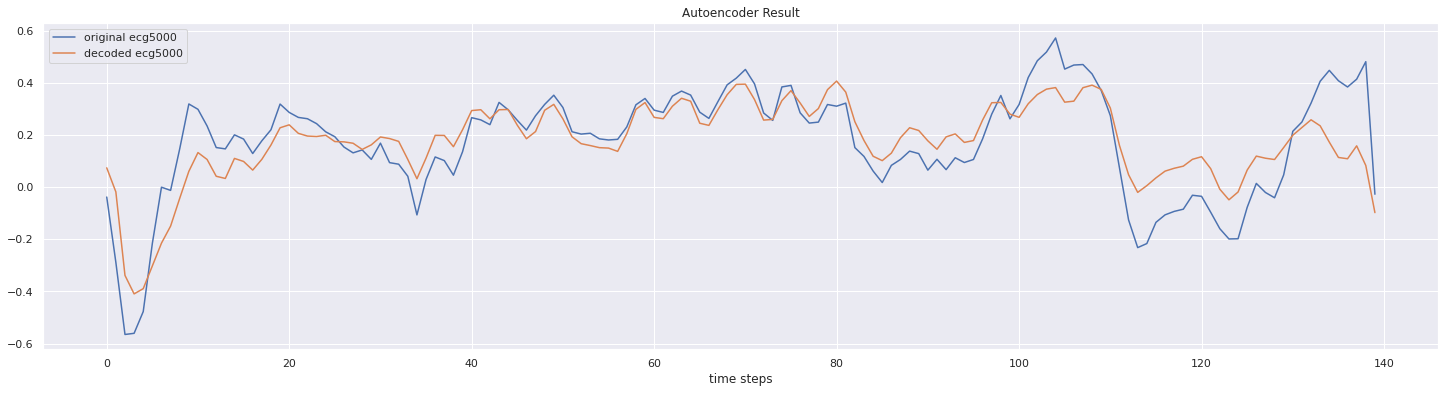

In [42]:
### Plot only one sample
i = 934 # indize/sample which is going to be plotted
plt.figure(linewidth = 1, figsize=(25,6))
plt.title('Autoencoder Result')
plt.xlabel('time steps')
plt.plot(new_x_train[i], label='original ecg5000')
plt.plot(new_decoded_ecg5000[i], label='decoded ecg5000')
plt.legend(loc="upper left")
plt.show()

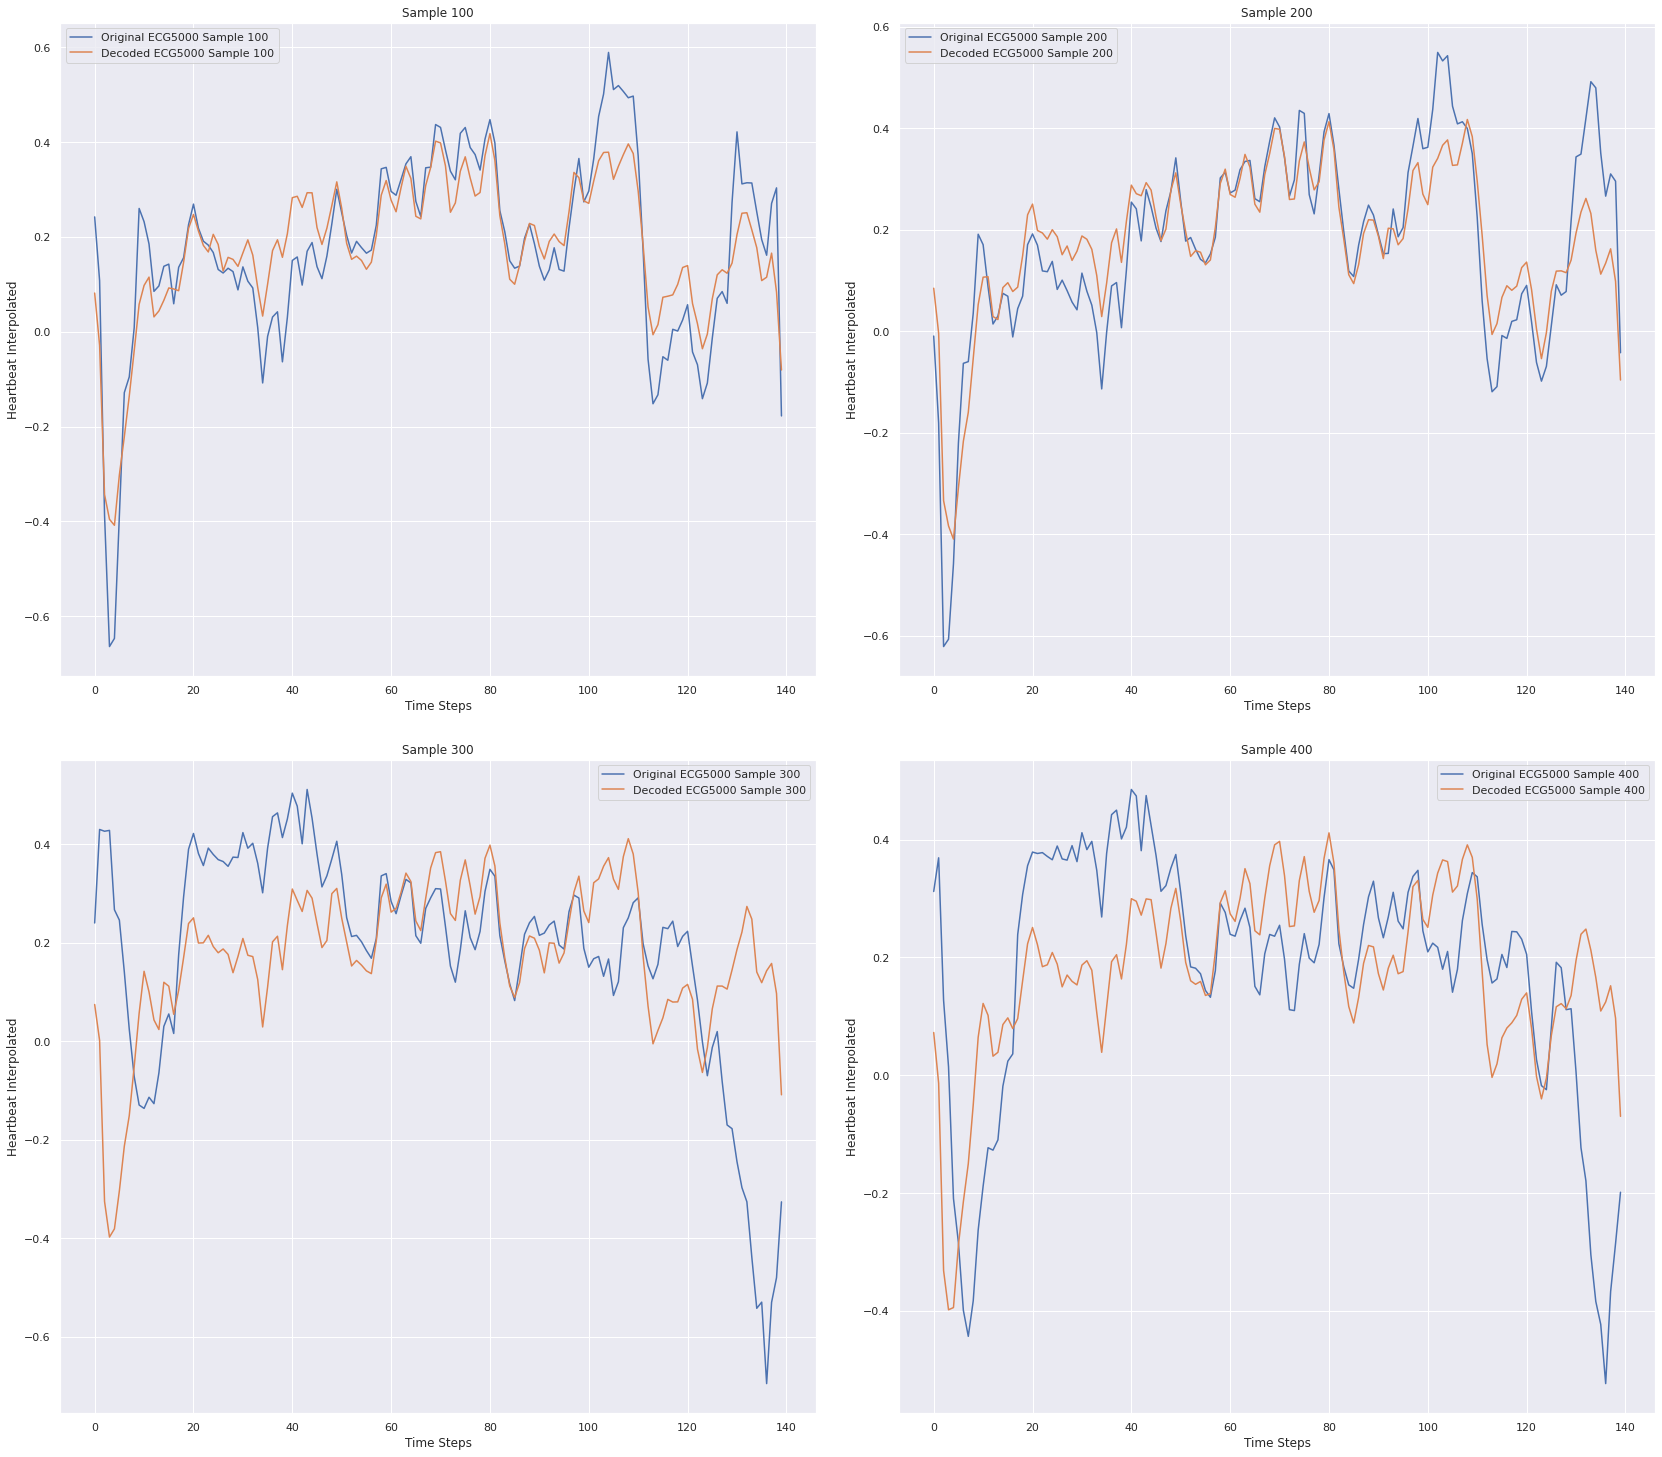

In [44]:
### Plot Multiple Samples
n_rows = 2                   
n_cols = 2

# Size Properties and layout design for tighter representation
fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(23,20))
fig.tight_layout(w_pad=4, h_pad = 5)

# Subplotting
i = 100
for row in range(n_rows):
  for col in range(n_cols):
    axs[row, col].plot(new_x_train[i])
    axs[row, col].plot(new_decoded_ecg5000[i])
    axs[row, col].legend(["Original ECG5000 Sample {}".format(i), "Decoded ECG5000 Sample {}".format(i)])
    axs[row, col].set(xlabel = "Time Steps", ylabel = "Heartbeat Interpolated", title = "Sample {}".format(i))
    i = i + 100
